# Random Forest Implementation

In [1]:
## Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler

## Key Methods that will be used in the Code

In [2]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)  
    # Normalize/Standardize data
    scaler = StandardScaler()
    features = data.drop('violent_crime', axis=1) # Assuming 'violent_crime' is the target variable
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, data['violent_crime']

In [3]:
def split_data(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [4]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, f1, precision, roc_auc, report

In [5]:
def evaluate_model_with_cross_validation(model, X, y, scoring='accuracy', cv=5):
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    mean_score = scores.mean()
    std_dev_score = scores.std()

    return mean_score, std_dev_score

In [6]:
def show_correlation_matrix(data):
    corr_matrix = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Feature Correlation Matrix")
    plt.show()

    return corr_matrix

In [7]:
def show_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(indices)])
    plt.show()

In [8]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()

In [9]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
def plot_precision_recall(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, where='post', color='b', alpha=0.7)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

In [11]:
def apply_pca_and_identify_features(X_train, X_test, data_columns, top_n=3):
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Extracting the influence of each feature on each principal component
    components = pca.components_
    
    # Identifying top contributing features for each principal component
    top_features_per_component = {}
    for i, component in enumerate(components):
        # Getting indices of top contributing features for this component
        top_feature_indices = np.argsort(-np.abs(component))[:top_n]
        # Mapping indices to feature names
        top_features = [data_columns[idx] for idx in top_feature_indices]
        top_features_per_component[i] = top_features

    return X_train_pca, X_test_pca, pca.n_components_, top_features_per_component

In [12]:
def feature_selection(X_train, y_train, data_columns, n_features='auto'):
    rf = RandomForestClassifier(random_state=42)
    sfs = SequentialFeatureSelector(rf, n_features_to_select=n_features, direction='forward')
    sfs.fit(X_train, y_train)
    selected_features_indices = sfs.get_support(indices=True)
    selected_feature_names = [data_columns[i] for i in selected_features_indices]

    # Removing duplicates in the selected features list
    unique_selected_feature_names = list(dict.fromkeys(selected_feature_names))

    return selected_features_indices, unique_selected_feature_names

In [13]:
def hyperparameter_tuning(X_train, y_train):
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
        'max_depth': [10, 20, 30, 40, 50, None],    # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at a leaf node
        'bootstrap': [True, False],                 # Method of selecting samples for training each tree
        'criterion': ['gini', 'entropy']            # Function to measure the quality of a split
    }
    grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_params_, grid_search.best_score_

## Training of Classifier with Evaluation

In [14]:
print("--------------- Training a Random Forest Classifier ---------------\n")
file_path = 'sampled_file_100k.csv'

--------------- Training a Random Forest Classifier ---------------



In [15]:
features, target = load_and_preprocess_data(file_path)
data = pd.read_csv(file_path)

In [16]:
X_train, X_test, y_train, y_test = split_data(features, target)

In [17]:
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train, y_train)
y_pred_original = rf_original.predict(X_test)
y_scores_original = rf_original.predict_proba(X_test)[:, 1]

In [18]:
accuracy_orig, f1_orig, precision_orig, roc_auc_orig, report_orig = train_and_evaluate_model(X_train, X_test, y_train, y_test)

print("--------------- Evaluation Metrics on Original Data ---------------\n")
print(f"Accuracy: {accuracy_orig}, F1 Score: {f1_orig}, Precision: {precision_orig}, ROC-AUC: {roc_auc_orig}")
print(f"Classification Report:\n{report_orig}")

--------------- Evaluation Metrics on Original Data ---------------

Accuracy: 0.95515, F1 Score: 0.8470066518847007, Precision: 0.9491590214067278, ROC-AUC: 0.8783835028669141
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     16753
           1       0.95      0.76      0.85      3247

    accuracy                           0.96     20000
   macro avg       0.95      0.88      0.91     20000
weighted avg       0.95      0.96      0.95     20000



In [19]:
print("--------------- Standard Deviation of Evaluation Metrics on Original Data ---------------\n")
accuracy_mean_orig, accuracy_std_orig = evaluate_model_with_cross_validation(rf_original, X_train, y_train, scoring='accuracy')
f1_mean_orig, f1_std_orig = evaluate_model_with_cross_validation(rf_original, X_train, y_train, scoring='f1')
precision_mean_orig, precision_std_orig = evaluate_model_with_cross_validation(rf_original, X_train, y_train, scoring='precision')
roc_auc_mean_orig, roc_auc_std_orig = evaluate_model_with_cross_validation(rf_original, X_train, y_train, scoring='roc_auc')

print(f"Accuracy: Mean = {accuracy_mean_orig}, Std Dev = {accuracy_std_orig}")
print(f"F1 Score: Mean = {f1_mean_orig}, Std Dev = {f1_std_orig}")
print(f"Precision: Mean = {precision_mean_orig}, Std Dev = {precision_std_orig}")
print(f"ROC-AUC: Mean = {roc_auc_mean_orig}, Std Dev = {roc_auc_std_orig}")

--------------- Standard Deviation of Evaluation Metrics on Original Data ---------------

Accuracy: Mean = 0.95755, Std Dev = 0.0012192466936596714
F1 Score: Mean = 0.8534369807550481, Std Dev = 0.004431792375561927
Precision: Mean = 0.9465733238475492, Std Dev = 0.0034022179379828987
ROC-AUC: Mean = 0.9714848773590484, Std Dev = 0.00227587347971861


--------------- Correlation Matrix on Original Data ---------------



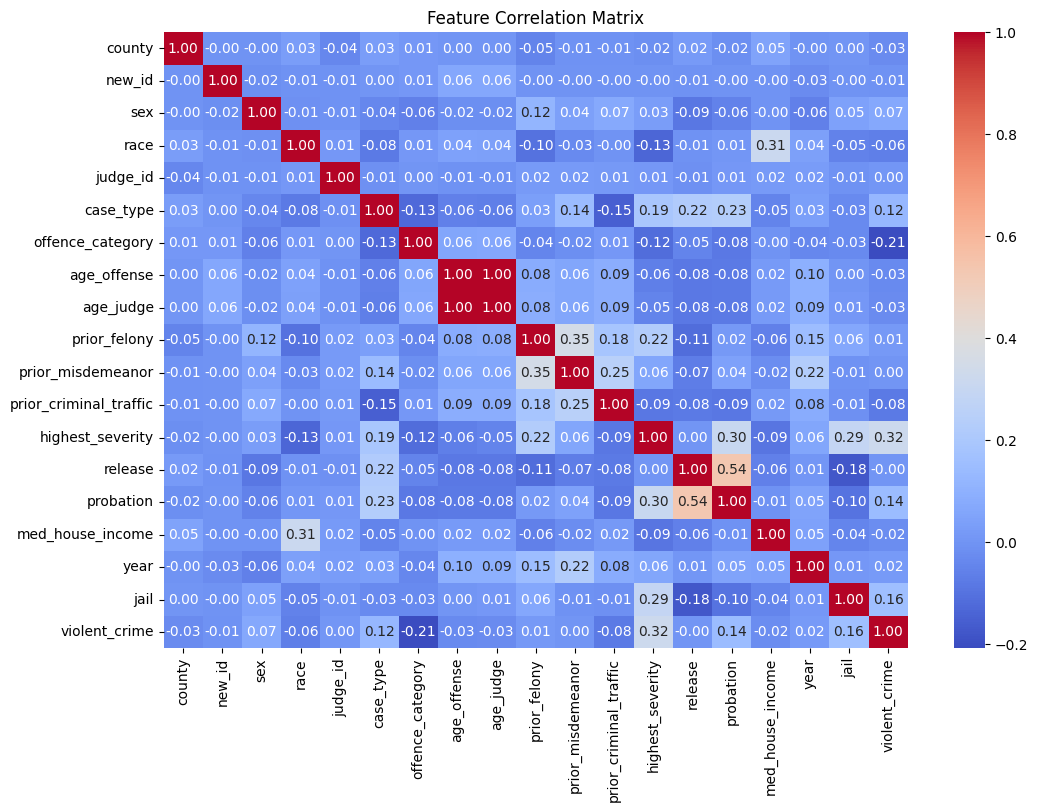

In [20]:
print("--------------- Correlation Matrix on Original Data ---------------\n")
corr_matrix = show_correlation_matrix(data)

--------------- Feature Importance ---------------



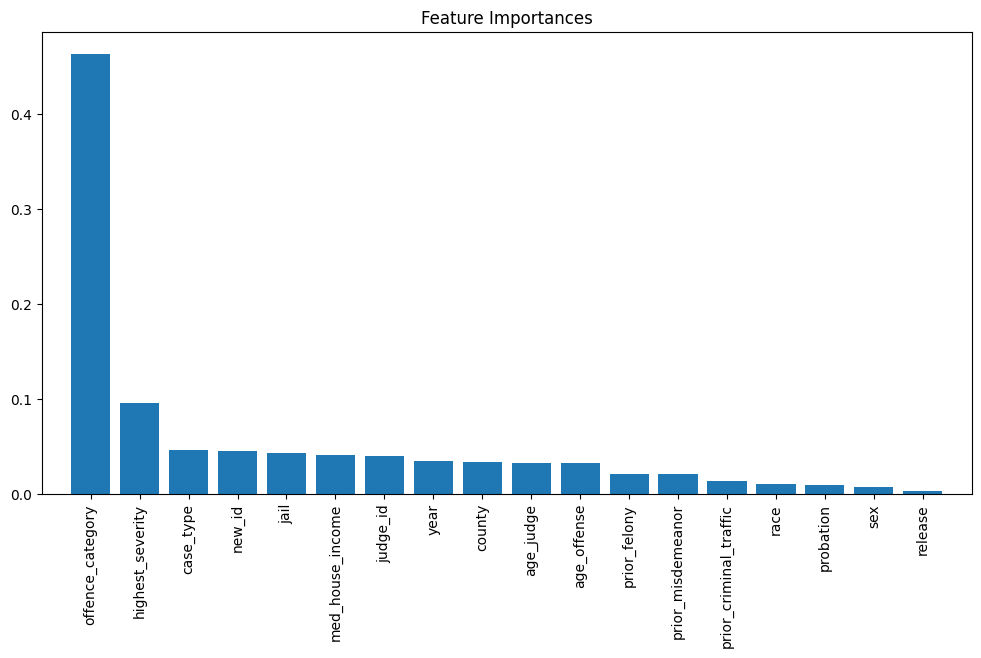

In [21]:
print("--------------- Feature Importance ---------------\n")
show_feature_importance(rf_original, data.columns[:-1])

--------------- Confusion Matrix ---------------



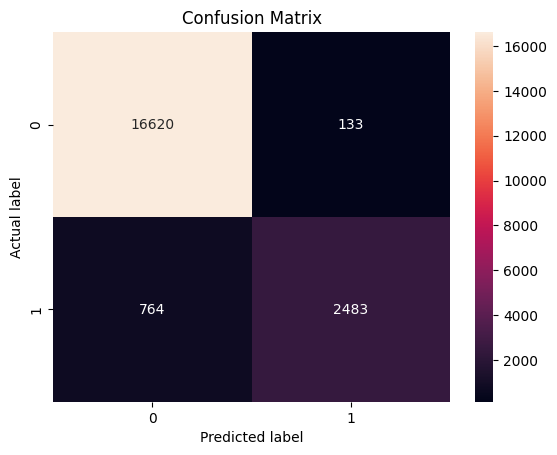

--------------- ROC Curve ---------------



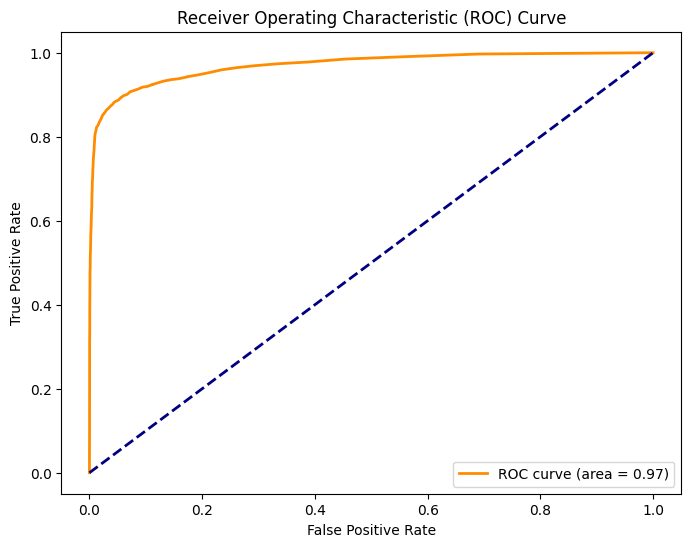

--------------- Precision-Recall Curve ---------------



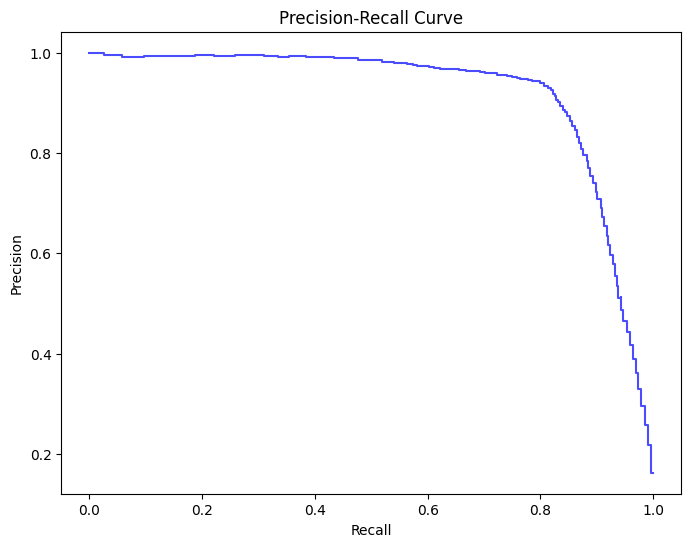

In [22]:
print("--------------- Confusion Matrix ---------------\n")
plot_confusion_matrix(y_test, y_pred_original)

print("--------------- ROC Curve ---------------\n")
plot_roc_curve(y_test, y_scores_original)

print("--------------- Precision-Recall Curve ---------------\n")
plot_precision_recall(y_test, y_scores_original)

In [23]:
print("--------------- PCA ---------------\n")
data_columns = data.drop('violent_crime', axis=1).columns
X_train_pca, X_test_pca, n_pca_components, top_features_per_component = apply_pca_and_identify_features(X_train, X_test, data_columns, top_n=3)
print(f"PCA Components: {n_pca_components}")
for component, features in top_features_per_component.items():
    print(f"Component {component}: {features}")

--------------- PCA ---------------

PCA Components: 16
Component 0: ['age_offense', 'age_judge', 'probation']
Component 1: ['highest_severity', 'prior_felony', 'prior_misdemeanor']
Component 2: ['release', 'probation', 'age_offense']
Component 3: ['med_house_income', 'race', 'prior_misdemeanor']
Component 4: ['med_house_income', 'race', 'jail']
Component 5: ['judge_id', 'sex', 'county']
Component 6: ['sex', 'county', 'judge_id']
Component 7: ['new_id', 'offence_category', 'med_house_income']
Component 8: ['county', 'offence_category', 'judge_id']
Component 9: ['judge_id', 'offence_category', 'case_type']
Component 10: ['offence_category', 'prior_criminal_traffic', 'case_type']
Component 11: ['year', 'sex', 'prior_criminal_traffic']
Component 12: ['prior_felony', 'jail', 'case_type']
Component 13: ['race', 'med_house_income', 'prior_criminal_traffic']
Component 14: ['highest_severity', 'jail', 'prior_criminal_traffic']
Component 15: ['prior_misdemeanor', 'prior_felony', 'case_type']


In [25]:
print("--------------- Front Feature Selection ---------------\n")
selected_features_indices, selected_feature_names = feature_selection(X_train_pca, y_train, data_columns)
print(f"Selected Features after PCA and FFS: {selected_feature_names}")

--------------- Front Feature Selection ---------------

Selected Features after PCA and FFS: ['county', 'new_id', 'race', 'judge_id', 'prior_misdemeanor', 'highest_severity', 'probation', 'med_house_income']


In [26]:
rf_transformed = RandomForestClassifier(random_state=42)
rf_transformed.fit(X_train_pca[:, selected_features_indices], y_train)
y_pred_transformed = rf_transformed.predict(X_test_pca[:, selected_features_indices])
y_scores_transformed = rf_transformed.predict_proba(X_test_pca[:, selected_features_indices])[:, 1]

In [27]:
X_train_transformed = X_train_pca[:, selected_features_indices]
X_test_transformed = X_test_pca[:, selected_features_indices]
accuracy_pca_ffs, f1_pca_ffs, precision_pca_ffs, roc_auc_pca_ffs, report_pca_ffs = train_and_evaluate_model(X_train_transformed, X_test_transformed, y_train, y_test)

print("--------------- Evaluation Metrics on Transformed Data ---------------\n")
print(f"Accuracy: {accuracy_pca_ffs}, F1 Score: {f1_pca_ffs}, Precision: {precision_pca_ffs}, ROC-AUC: {roc_auc_pca_ffs}")
print(f"Classification Report:\n{report_pca_ffs}")

--------------- Evaluation Metrics on Transformed Data ---------------

Accuracy: 0.85515, F1 Score: 0.2689881402977542, Precision: 0.744413407821229, ROC-AUC: 0.5766140538913265
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     16753
           1       0.74      0.16      0.27      3247

    accuracy                           0.86     20000
   macro avg       0.80      0.58      0.59     20000
weighted avg       0.84      0.86      0.81     20000



In [28]:
print("--------------- Standard Deviation of Evaluation Metrics on Transformed Data ---------------\n")
accuracy_mean_trans, accuracy_std_trans = evaluate_model_with_cross_validation(rf_transformed, X_train_pca[:, selected_features_indices], y_train, scoring='accuracy')
f1_mean_trans, f1_std_trans = evaluate_model_with_cross_validation(rf_transformed, X_train_pca[:, selected_features_indices], y_train, scoring='f1')
precision_mean_trans, precision_std_trans = evaluate_model_with_cross_validation(rf_transformed, X_train_pca[:, selected_features_indices], y_train, scoring='precision')
roc_auc_mean_trans, roc_auc_std_trans = evaluate_model_with_cross_validation(rf_transformed, X_train_pca[:, selected_features_indices], y_train, scoring='roc_auc')

print(f"Accuracy: Mean = {accuracy_mean_trans}, Std Dev = {accuracy_std_trans}")
print(f"F1 Score: Mean = {f1_mean_trans}, Std Dev = {f1_std_trans}")
print(f"Precision: Mean = {precision_mean_trans}, Std Dev = {precision_std_trans}")
print(f"ROC-AUC: Mean = {roc_auc_mean_trans}, Std Dev = {roc_auc_std_trans}")

--------------- Standard Deviation of Evaluation Metrics on Transformed Data ---------------

Accuracy: Mean = 0.8581875, Std Dev = 0.0013445491809524898
F1 Score: Mean = 0.28252435740908743, Std Dev = 0.007950381335660511
Precision: Mean = 0.7239795065989373, Std Dev = 0.019039236405454213
ROC-AUC: Mean = 0.8282568967150443, Std Dev = 0.0018837440745473842


--------------- Confusion Matrix ---------------



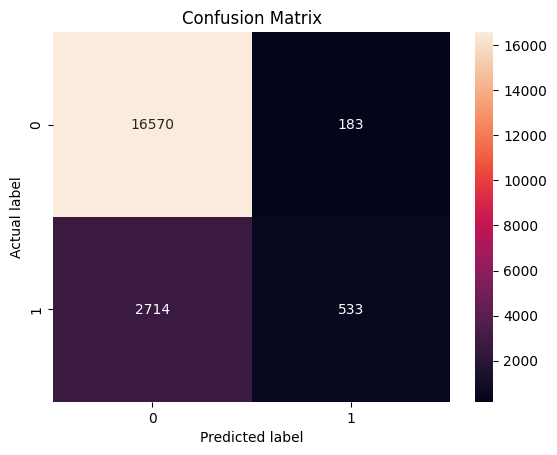

--------------- ROC Curve ---------------



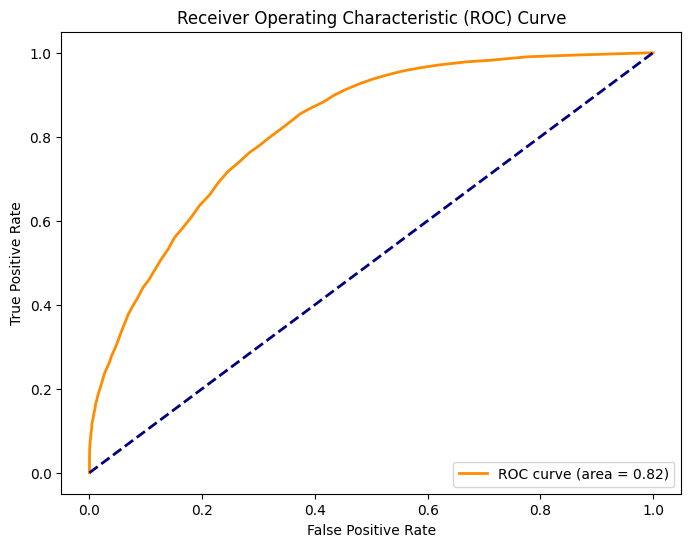

--------------- Precision-Recall Curve ---------------



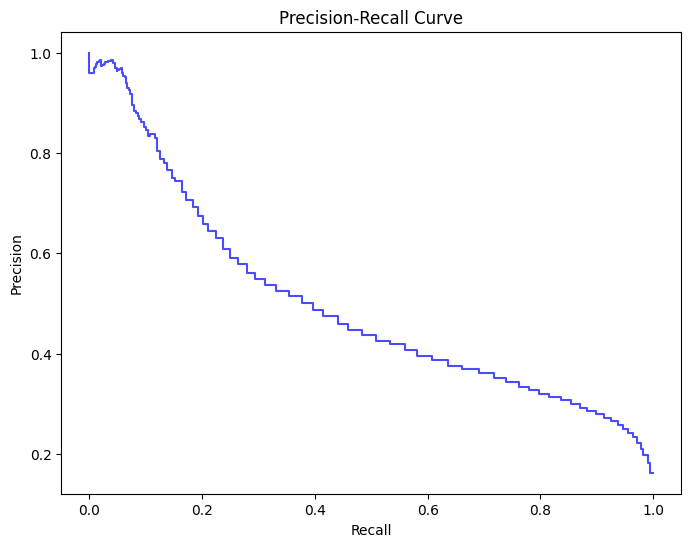

In [29]:
print("--------------- Confusion Matrix ---------------\n")
plot_confusion_matrix(y_test, y_pred_transformed)

print("--------------- ROC Curve ---------------\n")
plot_roc_curve(y_test, y_scores_transformed)

print("--------------- Precision-Recall Curve ---------------\n")
plot_precision_recall(y_test, y_scores_transformed)

In [31]:
print("--------------- Hyperparameter Tuning ---------------\n")

--------------- Hyperparameter Tuning ---------------



In [30]:
# Hyperparameter Tuning on Transformed Data
best_params, best_score = hyperparameter_tuning(X_train_transformed, y_train)
print(f"Best Hyperparameters: {best_params}, Best Score: {best_score}")

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best Hyperparameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}, Best Score: 0.8600625


In [38]:
# Retraining the model
tuned_rf = RandomForestClassifier(**best_params, random_state=42)
tuned_rf.fit(X_train_transformed, y_train)
y_pred_tuned = tuned_rf.predict(X_test_transformed)
y_scores_tuned = tuned_rf.predict_proba(X_test_transformed)[:, 1]

In [41]:
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_scores_tuned)

print("--------------- Evaluation Metrics for Tuned Model ---------------\n")
print(f"Accuracy: {accuracy_tuned}, F1 Score: {f1_tuned}, Precision: {precision_tuned}, ROC-AUC: {roc_auc_tuned}")
report_tuned = classification_report(y_test, y_pred_tuned)
print("Classification Report:\n", report_tuned)

--------------- Evaluation Metrics for Tuned Model ---------------

Accuracy: 0.85635, F1 Score: 0.2960058809115413, Precision: 0.7242206235011991, ROC-AUC: 0.8259379181469797
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92     16753
           1       0.72      0.19      0.30      3247

    accuracy                           0.86     20000
   macro avg       0.79      0.59      0.61     20000
weighted avg       0.84      0.86      0.82     20000



In [42]:
print("\n--------------- Standard Deviation of Evaluation Metrics on Tuned Model ---------------\n")
accuracy_std_trans = evaluate_model_with_cross_validation(tuned_rf, X_train_transformed, y_train, scoring='accuracy')[1]
f1_std_trans = evaluate_model_with_cross_validation(tuned_rf, X_train_transformed, y_train, scoring='f1')[1]
precision_std_trans = evaluate_model_with_cross_validation(tuned_rf, X_train_transformed, y_train, scoring='precision')[1]
roc_auc_std_trans = evaluate_model_with_cross_validation(tuned_rf, X_train_transformed, y_train, scoring='roc_auc')[1]

print(f"Accuracy Std Dev: {accuracy_std_trans}")
print(f"F1 Score Std Dev: {f1_std_trans}")
print(f"Precision Std Dev: {precision_std_trans}")
print(f"ROC-AUC Std Dev: {roc_auc_std_trans}")


--------------- Standard Deviation of Evaluation Metrics on Tuned Model ---------------

Accuracy Std Dev: 0.0012568561970249567
F1 Score Std Dev: 0.00884821932027884
Precision Std Dev: 0.017327536924097397
ROC-AUC Std Dev: 0.001998327538538378


--------------- Feature Importance on Tuned Model ---------------



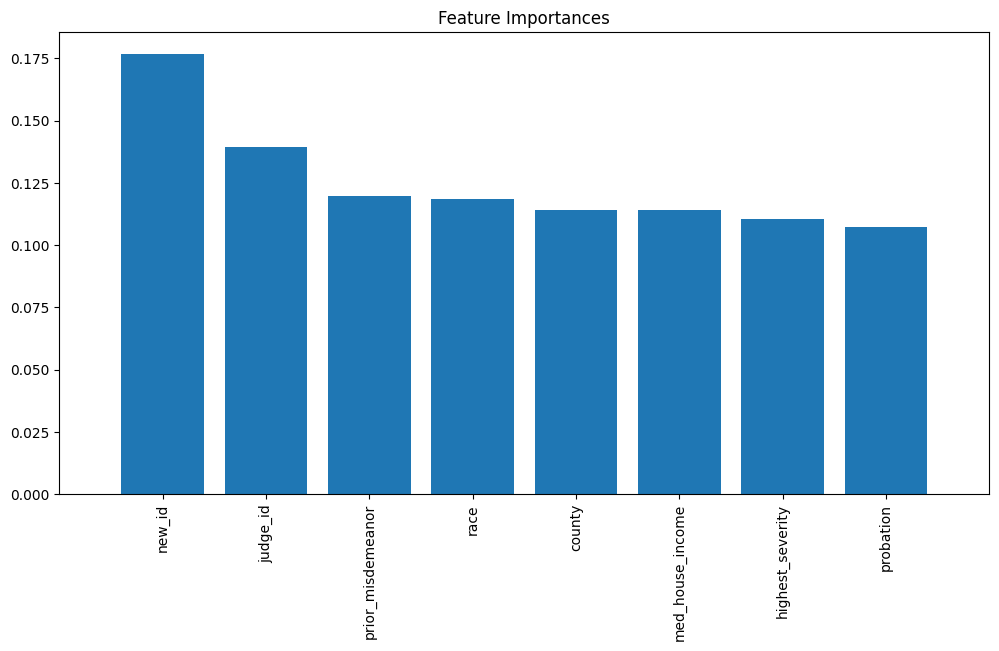

In [43]:
print("--------------- Feature Importance on Tuned Model ---------------\n")
show_feature_importance(tuned_rf, [data.columns[i] for i in selected_features_indices])

--------------- Confusion Matrix ---------------



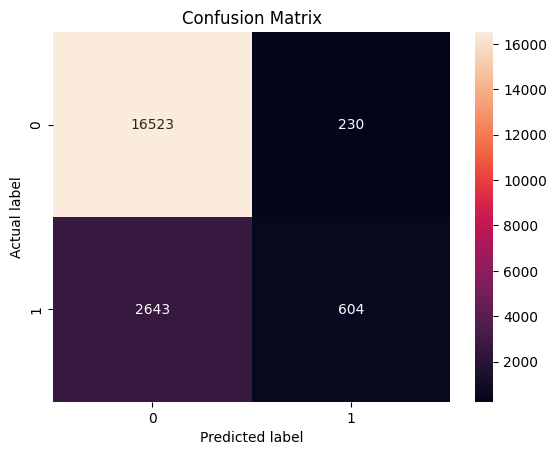

--------------- ROC Curve ---------------



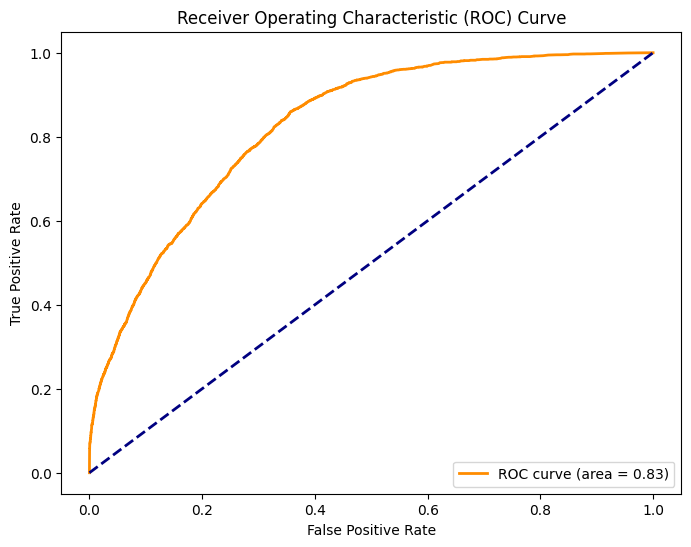

--------------- Precision-Recall Curve ---------------



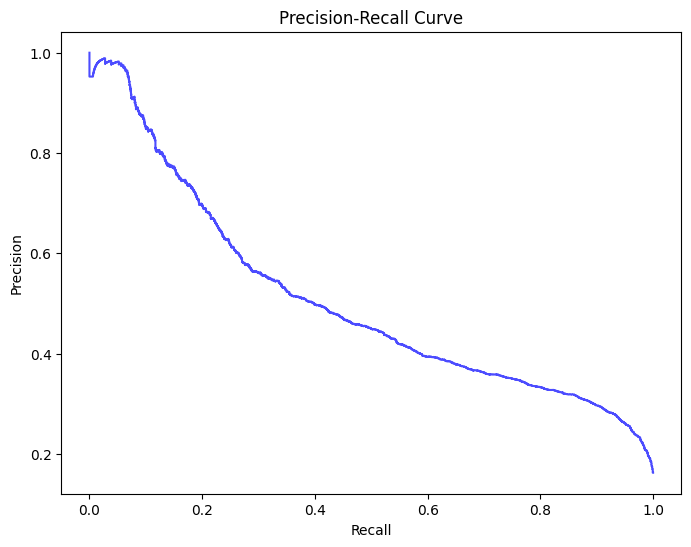

In [44]:
print("--------------- Confusion Matrix ---------------\n")
plot_confusion_matrix(y_test, y_pred_tuned)

print("--------------- ROC Curve ---------------\n")
plot_roc_curve(y_test, y_scores_tuned)

print("--------------- Precision-Recall Curve ---------------\n")
plot_precision_recall(y_test, y_scores_tuned)

## Exporting the Model

In [46]:
## Importing the necessary library
import joblib

model_filename = 'model/tuned_random_forest_model.joblib'
# Saving the model
joblib.dump(tuned_rf, model_filename)

['model/tuned_random_forest_model.joblib']